# saved models are named as FreeSound_1D_conv_

In [1]:
import os
import pickle
import pandas as pd
import librosa
import librosa.display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm
from torchsummary import summary
import torch.optim as optim
os.listdir('data/freesound-audio-tagging')

['audio_test',
 'audio_train',
 'free_sound_11025.pkl',
 'free_sound_22050.pkl',
 'sample_submission.csv',
 'test_post_competition.csv',
 'train.csv',
 'train_post_competition.csv']

In [2]:
len(os.listdir('data/freesound-audio-tagging/audio_train'))
df = pd.read_csv('data/freesound-audio-tagging/train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [3]:
pickle.dump(Loaded_data, open('data/freesound-audio-tagging/free_sound_11025.pkl', 'wb'))

NameError: name 'Loaded_data' is not defined

In [4]:
Loaded_data = {}
if os.path.exists('data/freesound-audio-tagging/free_sound_11025.pkl'):
    Loaded_data = pickle.load(open('data/freesound-audio-tagging/free_sound_11025.pkl', 'rb'))
    
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

def load_audio_file(file_path, input_length=4096):
    
    if file_path not in Loaded_data:
        data = librosa.core.load(file_path, sr=None) 
        data = librosa.core.resample(data[0], data[1], 11025)
        Loaded_data[file_path] = data
    else:
        data = Loaded_data[file_path]
    
    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:input_length+offset]
        
    else:
        T = np.zeros(input_length, dtype=float)
        T[:len(data)] = data
        data = T
        #max_offset = input_length - len(data)
        ##offset = np.random.randint(max_offset)
        #data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
    data = audio_norm(data)
    return np.array([data])

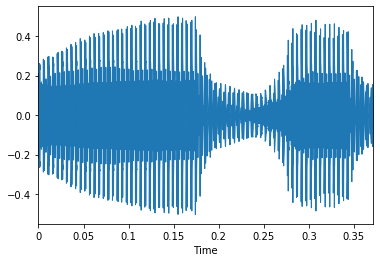

In [5]:
librosa.display.waveplot(load_audio_file('data/freesound-audio-tagging/audio_train/001ca53d.wav')[0],
                         sr=11025, 
                         max_points=50000.0, 
                         x_axis='time', 
                         offset=0.0)

# Data Loading

In [5]:
labels = sorted(set(df.label))
label_to_indice = {l:i for i,l in enumerate(labels)}
indice_to_label = {i:l for i,l in enumerate(labels)}

In [6]:
class FreeSoundDataset(torch.utils.data.Dataset):
    def __init__(self, df_path, data_path, train=True, split=0.8):
        
        self.df = pd.read_csv(df_path)
        
        self.df = self.df[:int(len(self.df)*split)] if train else self.df[int(len(self.df)*split):]
        
        self.data_path = data_path
        self.input_length = 4096
        self.batch_size = 32
        
        self.labels = sorted(set(self.df.label))
        self.label_to_indice = {l:i for i,l in enumerate(self.labels)}
        self.indice_to_label = {i:l for i,l in enumerate(self.labels)}
    
    def __len__(self):
        return len(self.df)-2
    
    def __getitem__(self, idx):
        file_path = self.data_path + list(df[idx: idx+1].fname)[0]
        label_indice = label_to_indice[list(df[idx: idx+1].label)[0]]
        return load_audio_file(file_path), label_indice
        

In [7]:
sr = 11025
def bandpass_filter(signal, low, high, order = 5):
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    y = sosfilt(sos, signal)
    return y
    
def make_signal(raw_signal, nyq = sr/2):
    return_signal = np.zeros((8, self.input_length))
    return_signal[0] = raw_signal

    cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
    for i in range(1, len(cut_offs), 1):
        return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])
    return return_signal
        
    
def shuffletwo(x, y):
    rng_state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(rng_state)
    np.random.shuffle(y)

In [65]:
mini_batch_size = 64
FreeSoundData = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                 'data/freesound-audio-tagging/audio_train/')
FreeSoundDataTest = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                     'data/freesound-audio-tagging/audio_train/',
                                     train=False)
FreeSoundDataLoader = DataLoader(FreeSoundData, batch_size=mini_batch_size, shuffle=True)
FreeSoundDataTestLoader = DataLoader(FreeSoundDataTest, batch_size=mini_batch_size, shuffle=True)

In [47]:
FreeSoundData[0][0].shape

(1, 4096)

# Model

In [61]:
class FreeSound_Sense(torch.nn.Module):
    
    def __init__(self):
        super(FreeSound_Sense, self).__init__()
        self.conv1d_1_16_9 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=9)
        self.conv1d_16_16_9 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=9)
        self.conv1d_16_32_3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv1d_32_32_3_1 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv1d_32_32_3_2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv1d_32_32_3_3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv1d_32_96_3 = nn.Conv1d(in_channels=32, out_channels=96, kernel_size=3)
        self.conv1d_96_96_3 = nn.Conv1d(in_channels=96, out_channels=96, kernel_size=3)
        
        self.maxpool_16 = nn.MaxPool1d(16)
        self.maxpool_4 = nn.MaxPool1d(4)
        self.maxpool_2 = nn.MaxPool1d(2)
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
        self.fc_96_64 = nn.Linear(in_features=96, out_features=64)
        self.fc_64_512 = nn.Linear(in_features=64, out_features=512)
        self.fc_512_42 = nn.Linear(in_features=512, out_features=42)
        
        
    def forward(self, x):
        
        # First Block
        x = self.conv1d_1_16_9(x)
        x = self.relu(x)
        x = self.conv1d_16_16_9(x)
        x = self.relu(x)
        x = self.maxpool_16(x)
        x = self.dropout(x)
        
        # Second Block
        x = self.conv1d_16_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3_1(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Third Block
        x = self.conv1d_32_32_3_2(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Fourth Block
        x = self.conv1d_32_96_3(x)
        x = self.relu(x)
        x = self.conv1d_96_96_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = torch.mean(x, 2)
 
        # Final Layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc_96_64(x)
        x = self.relu(x)
        x = self.fc_64_512(x)
        x = self.relu(x)
        x = self.fc_512_42(x)
        x = self.softmax(x)
        
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)
summary(Model, (1, 4096))

from thop import profile
macs, params = profile(FreeSound_Sense().to(device), inputs=(torch.randn(1, 1, 4096).to(device), ))
macs, params

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 4088]             160
              ReLU-2             [-1, 16, 4088]               0
            Conv1d-3             [-1, 16, 4080]           2,320
              ReLU-4             [-1, 16, 4080]               0
         MaxPool1d-5              [-1, 16, 255]               0
           Dropout-6              [-1, 16, 255]               0
            Conv1d-7              [-1, 32, 253]           1,568
              ReLU-8              [-1, 32, 253]               0
            Conv1d-9              [-1, 32, 251]           3,104
             ReLU-10              [-1, 32, 251]               0
        MaxPool1d-11               [-1, 32, 62]               0
          Dropout-12               [-1, 32, 62]               0
           Conv1d-13               [-1, 32, 60]           3,104
             ReLU-14               [-1,

(12111360.0, 111450.0)

In [ ]:
'''
class FreeSound_Sense(torch.nn.Module):
    
    def __init__(self):
        super(FreeSound_Sense, self).__init__()
        self.conv1d_1_16_9 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=9)
        self.conv1d_16_16_9 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=9)
        self.conv1d_16_48_3 = nn.Conv1d(in_channels=16, out_channels=48, kernel_size=3)
        self.conv1d_48_48_3 = nn.Conv1d(in_channels=48, out_channels=48, kernel_size=3)
        self.conv1d_48_96_3 = nn.Conv1d(in_channels=48, out_channels=96, kernel_size=3)
        self.conv1d_96_96_3 = nn.Conv1d(in_channels=96, out_channels=96, kernel_size=3)
        #self.conv1d_32_96_3 = nn.Conv1d(in_channels=32, out_channels=96, kernel_size=3)
        #self.conv1d_96_96_3 = nn.Conv1d(in_channels=96, out_channels=96, kernel_size=3)
        
        self.maxpool_16 = nn.MaxPool1d(16)
        self.maxpool_4 = nn.MaxPool1d(4)
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
        self.fc_96_64 = nn.Linear(in_features=96, out_features=64)
        self.fc_64_512 = nn.Linear(in_features=64, out_features=512)
        self.fc_512_42 = nn.Linear(in_features=512, out_features=42)
        
        
    def forward(self, x):
        
        # First Block
        x = self.conv1d_1_16_9(x)
        x = self.relu(x)
        x = self.conv1d_16_16_9(x)
        x = self.relu(x)
        x = self.maxpool_16(x)
        x = self.dropout(x)
        
        # Second Block
        x = self.conv1d_16_48_3(x)
        x = self.relu(x)
        x = self.conv1d_48_48_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Third Block
        x = self.conv1d_48_96_3(x)
        x = self.relu(x)
        x = self.conv1d_96_96_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = torch.mean(x, 2)
 
        # Final Layers
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.fc_96_64(x)
        x = self.relu(x)
        x = self.fc_64_512(x)
        x = self.relu(x)
        x = self.fc_512_42(x)
        x = self.softmax(x)
        
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)
summary(Model, (1, 4096))

from thop import profile
macs, params = profile(Model, inputs=(torch.randn(1, 1, 4096).to(device), ))
macs, params
'''

In [66]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(Model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [67]:
epoch_progress_bar = tqdm.tqdm(range(0, 500))
for epoch in epoch_progress_bar:
    avg_epoch_loss = 0
    data_progress_bar = tqdm.tqdm(FreeSoundDataLoader)
    positives=0
    for data, targets in data_progress_bar:
        data = data.float().to(device)
        targets = targets.long().to(device)
        

        optimizer.zero_grad()
        outputs = Model(data)
        

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        avg_epoch_loss+=loss_val
        data_progress_bar.set_description(desc="Loss: "+str(loss_val))
        
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        targets = targets.cpu().numpy()
        positives += np.sum(targets==outputs)
    
    print('Epoch Loss: ', str(avg_epoch_loss/len(FreeSoundDataLoader)))
    print('Train Acc ', str(positives*100/(len(FreeSoundDataLoader)*mini_batch_size)))
    
    # Validation
    data_test_progress_bar = tqdm.tqdm(FreeSoundDataTestLoader)
    positives=0
    for data, targets in data_test_progress_bar:
        data = data.float().to(device)
        targets = targets.numpy()
        outputs = Model(data)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        positives += np.sum(targets==outputs)
        
    print('Valid Acc ', str(positives*100/(len(FreeSoundDataTestLoader)*mini_batch_size)))


Epoch Loss:  3.732868312787609
Train Acc  3.125



Valid Acc  2.8125



Epoch Loss:  3.721238889614073
Train Acc  3.177521008403361



Valid Acc  4.947916666666667



Epoch Loss:  3.710458410888159
Train Acc  5.86922268907563



Valid Acc  6.875



Epoch Loss:  3.699663462759066
Train Acc  6.998424369747899



Valid Acc  6.197916666666667



Epoch Loss:  3.702116202907402
Train Acc  6.8146008403361344



Valid Acc  8.75



Epoch Loss:  3.6924848436307505
Train Acc  8.324579831932773



Valid Acc  7.96875



Epoch Loss:  3.688406671796526
Train Acc  8.60031512605042



Valid Acc  8.958333333333334



Epoch Loss:  3.6838655832434903
Train Acc  9.151785714285714



Valid Acc  9.635416666666666



Epoch Loss:  3.683607273742932
Train Acc  9.007352941176471



Valid Acc  9.6875



Epoch Loss:  3.6748556469668863
Train Acc  10.044642857142858



Valid Acc  10.208333333333334



Epoch Loss:  3.670729534966605
Train Acc  10.412289915966387



Valid Acc  7.8125



Epoch Loss:  3.6723009758636733
Train Acc  10.202205882352942



Valid Acc  9.739583333333334



Epoch Loss:  3.6654210391164828
Train Acc  10.89810924369748



Valid Acc  10.46875



Epoch Loss:  3.660842120146551
Train Acc  11.580882352941176



Valid Acc  11.041666666666666



Epoch Loss:  3.657988145571797
Train Acc  11.843487394957982



Valid Acc  11.302083333333334



Epoch Loss:  3.660801220340889
Train Acc  11.659663865546218



Valid Acc  11.25



Epoch Loss:  3.645915325950174
Train Acc  13.077731092436975



Valid Acc  11.510416666666666



Epoch Loss:  3.651598319286058
Train Acc  12.48686974789916



Valid Acc  9.21875



Epoch Loss:  3.6471358707972934
Train Acc  13.130252100840336



Valid Acc  9.427083333333334



Epoch Loss:  3.6585882351178083
Train Acc  11.7515756302521



Valid Acc  11.927083333333334



Epoch Loss:  3.6453415265604225
Train Acc  13.103991596638656



Valid Acc  13.072916666666666



Epoch Loss:  3.6442903590803386
Train Acc  13.169642857142858



Valid Acc  12.864583333333334



Epoch Loss:  3.6604204598595116
Train Acc  11.462710084033613



Valid Acc  13.125



Epoch Loss:  3.6481235127489104
Train Acc  12.801995798319327



Valid Acc  10.833333333333334



Epoch Loss:  3.6454885546900644
Train Acc  13.130252100840336



Valid Acc  11.614583333333334



Epoch Loss:  3.6483648664811077
Train Acc  12.841386554621849



Valid Acc  12.34375



Epoch Loss:  3.655602076474358
Train Acc  11.896008403361344



Valid Acc  14.21875



Epoch Loss:  3.6408077428320875
Train Acc  13.602941176470589



Valid Acc  10.885416666666666



Epoch Loss:  3.6506903291750357
Train Acc  12.605042016806722



Valid Acc  9.739583333333334



Epoch Loss:  3.6475459567639006
Train Acc  13.012079831932773



Valid Acc  13.072916666666666



Epoch Loss:  3.640502040125743
Train Acc  13.563550420168067



Valid Acc  13.75



Epoch Loss:  3.636530629727019
Train Acc  14.03623949579832



Valid Acc  13.125



Epoch Loss:  3.639155626296997
Train Acc  13.721113445378151



Valid Acc  12.760416666666666



Epoch Loss:  3.630469799041748
Train Acc  14.495798319327731



Valid Acc  13.854166666666666



Epoch Loss:  3.6357155226859725
Train Acc  14.03623949579832



Valid Acc  13.59375



Epoch Loss:  3.6364973432877483
Train Acc  14.04936974789916



Valid Acc  13.958333333333334



Epoch Loss:  3.6375639879402994
Train Acc  13.826155462184873



Valid Acc  14.166666666666666



Epoch Loss:  3.6310868243209455
Train Acc  14.508928571428571



Valid Acc  13.90625



Epoch Loss:  3.639370673844794
Train Acc  13.707983193277311



Valid Acc  13.4375



Epoch Loss:  3.6339850425720215
Train Acc  14.220063025210084



Valid Acc  14.53125



Epoch Loss:  3.6429176310531233
Train Acc  13.28781512605042



Valid Acc  13.75



Epoch Loss:  3.6335097901961384
Train Acc  14.141281512605042



Valid Acc  14.166666666666666



Epoch Loss:  3.6341387684605704
Train Acc  14.193802521008404



Valid Acc  13.59375



Epoch Loss:  3.6305086993369735
Train Acc  14.522058823529411



Valid Acc  14.895833333333334



Epoch Loss:  3.6299083012492717
Train Acc  14.679621848739496



Valid Acc  12.708333333333334



Epoch Loss:  3.634431652662133
Train Acc  14.220063025210084



Valid Acc  13.541666666666666



Epoch Loss:  3.6290188677170696
Train Acc  14.732142857142858



Valid Acc  13.177083333333334



Epoch Loss:  3.632667054649161
Train Acc  14.403886554621849



Valid Acc  14.010416666666666



Epoch Loss:  3.6296211651393344
Train Acc  14.653361344537815



Valid Acc  14.010416666666666



Epoch Loss:  3.632878353615769
Train Acc  14.351365546218487



Valid Acc  13.59375



Epoch Loss:  3.629203810411341
Train Acc  14.640231092436975



Valid Acc  14.270833333333334



Epoch Loss:  3.625684862377263
Train Acc  14.994747899159664



Valid Acc  14.375



Epoch Loss:  3.62654674954775
Train Acc  15.034138655462185



Valid Acc  13.75



Epoch Loss:  3.6330099626749504
Train Acc  14.246323529411764



Valid Acc  14.114583333333334



Epoch Loss:  3.626099189790357
Train Acc  15.112920168067227



Valid Acc  14.21875



Epoch Loss:  3.626766539421402
Train Acc  14.902836134453782



Valid Acc  14.375



Epoch Loss:  3.6285973536868057
Train Acc  14.797794117647058



Valid Acc  14.0625



Epoch Loss:  3.6234937735966275
Train Acc  15.283613445378151



Valid Acc  15.208333333333334



Epoch Loss:  3.6214187045057282
Train Acc  15.441176470588236



Valid Acc  15.208333333333334



Epoch Loss:  3.619439193180629
Train Acc  15.572478991596638



Valid Acc  14.895833333333334



Epoch Loss:  3.6255493725047394
Train Acc  15.191701680672269



Valid Acc  14.84375



Epoch Loss:  3.617716021898414
Train Acc  15.848214285714286



Valid Acc  15.052083333333334



Epoch Loss:  3.621651535274602
Train Acc  15.58560924369748



Valid Acc  14.947916666666666



Epoch Loss:  3.617205667896431
Train Acc  15.926995798319327



Valid Acc  14.791666666666666



Epoch Loss:  3.646693001274301
Train Acc  13.012079831932773



Valid Acc  14.010416666666666



Epoch Loss:  3.645486975918297
Train Acc  13.117121848739496



Valid Acc  12.604166666666666



Epoch Loss:  3.626061822185997
Train Acc  15.034138655462185



Valid Acc  14.53125



Epoch Loss:  3.6158330600802637
Train Acc  16.215861344537814



Valid Acc  15.208333333333334



Epoch Loss:  3.612539810292861
Train Acc  16.360294117647058



Valid Acc  14.53125



Epoch Loss:  3.6301457741681267
Train Acc  14.692752100840336



Valid Acc  15.260416666666666



Epoch Loss:  3.6245973891570786
Train Acc  15.139180672268907



Valid Acc  14.270833333333334



Epoch Loss:  3.6160711060051156
Train Acc  15.966386554621849



Valid Acc  15.9375



Epoch Loss:  3.6269963288507543
Train Acc  14.889705882352942



Valid Acc  12.34375



Epoch Loss:  3.6484059526138948
Train Acc  12.841386554621849



Valid Acc  10.78125



Epoch Loss:  3.6461869908981965
Train Acc  13.090861344537815



Valid Acc  15.416666666666666



Epoch Loss:  3.6147675053412174
Train Acc  16.228991596638654



Valid Acc  15.364583333333334



Epoch Loss:  3.6263874839333927
Train Acc  14.955357142857142



Valid Acc  13.958333333333334



Epoch Loss:  3.6238391499559417
Train Acc  15.296743697478991



Valid Acc  14.0625



Epoch Loss:  3.6242168751083503
Train Acc  15.217962184873949



Valid Acc  15.364583333333334



Epoch Loss:  3.619573599150201
Train Acc  15.756302521008404



Valid Acc  14.635416666666666



Epoch Loss:  3.6169677902670467
Train Acc  16.04516806722689



Valid Acc  14.895833333333334



Epoch Loss:  3.6144063512818154
Train Acc  16.176470588235293



Valid Acc  13.90625



Epoch Loss:  3.6197606595624396
Train Acc  15.625



Valid Acc  15.052083333333334



Epoch Loss:  3.6139339859746085
Train Acc  16.320903361344538



Valid Acc  15.364583333333334



Epoch Loss:  3.618425010633068
Train Acc  15.848214285714286



Valid Acc  15.625



Epoch Loss:  3.618634312092757
Train Acc  15.861344537815127



Valid Acc  15.15625



Epoch Loss:  3.621630947129065
Train Acc  15.533088235294118



Valid Acc  13.697916666666666



Epoch Loss:  3.635411883602623
Train Acc  14.0625



Valid Acc  14.6875



Epoch Loss:  3.623052288504208
Train Acc  15.401785714285714



Valid Acc  15.520833333333334



Epoch Loss:  3.618057373191128
Train Acc  15.821953781512605



Valid Acc  14.322916666666666



Epoch Loss:  3.625429293688606
Train Acc  15.112920168067227



Valid Acc  16.09375



Epoch Loss:  3.6184185913630893
Train Acc  15.795693277310924



Valid Acc  15.78125



Epoch Loss:  3.6191026002419093
Train Acc  15.795693277310924



Valid Acc  14.21875



Epoch Loss:  3.622682008422723
Train Acc  15.375525210084033



Valid Acc  15.104166666666666



Epoch Loss:  3.619145617765539
Train Acc  15.66439075630252



Valid Acc  12.916666666666666



Epoch Loss:  3.614732958689457
Train Acc  16.150210084033613



Valid Acc  16.041666666666668



Epoch Loss:  3.6105734580705144
Train Acc  16.596638655462186



Valid Acc  16.354166666666668



Epoch Loss:  3.6186911458728694
Train Acc  15.730042016806722



Valid Acc  16.145833333333332



Epoch Loss:  3.6106537911070493
Train Acc  16.701680672268907



Valid Acc  15.208333333333334



Epoch Loss:  3.6114161815963874
Train Acc  16.544117647058822



Valid Acc  15.520833333333334



Epoch Loss:  3.6156198397404005
Train Acc  16.04516806722689



Valid Acc  15.364583333333334



Epoch Loss:  3.620546589378549
Train Acc  15.61186974789916



Valid Acc  14.895833333333334



Epoch Loss:  3.6138936812136353
Train Acc  16.163340336134453



Valid Acc  14.479166666666666



Epoch Loss:  3.618977037798457
Train Acc  15.756302521008404



Valid Acc  15.208333333333334



Epoch Loss:  3.6152284866621516
Train Acc  16.071428571428573



Valid Acc  15.833333333333334



Epoch Loss:  3.60711741247097
Train Acc  16.951155462184875



Valid Acc  15.052083333333334



Epoch Loss:  3.6167109032638933
Train Acc  15.992647058823529



Valid Acc  14.791666666666666



Epoch Loss:  3.62298286061327
Train Acc  15.296743697478991



Valid Acc  12.552083333333334



Epoch Loss:  3.617162634344662
Train Acc  15.926995798319327



Valid Acc  15.0



Epoch Loss:  3.613483695422902
Train Acc  16.320903361344538



Valid Acc  15.15625



Epoch Loss:  3.61152929618579
Train Acc  16.478466386554622



Valid Acc  16.25



Epoch Loss:  3.6123724043870173
Train Acc  16.373424369747898



Valid Acc  15.677083333333334



Epoch Loss:  3.612867417455721
Train Acc  16.307773109243698



Valid Acc  14.947916666666666



Epoch Loss:  3.6243406884810505
Train Acc  15.244222689075631



Valid Acc  14.010416666666666



Epoch Loss:  3.6117206341078303
Train Acc  16.373424369747898



Valid Acc  16.145833333333332



Epoch Loss:  3.610805880121824
Train Acc  16.570378151260503



Valid Acc  15.46875



Epoch Loss:  3.6252707353159157
Train Acc  15.217962184873949



Valid Acc  11.71875



Epoch Loss:  3.6263558644206584
Train Acc  14.929096638655462



Valid Acc  15.520833333333334



Epoch Loss:  3.621478932244437
Train Acc  15.454306722689076



Valid Acc  14.166666666666666



Epoch Loss:  3.6235856328691756
Train Acc  15.428046218487395



Valid Acc  14.479166666666666



Epoch Loss:  3.6167516508022275
Train Acc  16.00577731092437



Valid Acc  15.0



Epoch Loss:  3.6160489671370564
Train Acc  16.04516806722689



Valid Acc  15.3125



Epoch Loss:  3.6126409578724066
Train Acc  16.399684873949578



Valid Acc  15.520833333333334



Epoch Loss:  3.611685590583737
Train Acc  16.399684873949578



Valid Acc  15.625



Epoch Loss:  3.613894410493995
Train Acc  16.334033613445378



Valid Acc  14.6875



Epoch Loss:  3.6103204578912558
Train Acc  16.75420168067227



Valid Acc  15.729166666666666



Epoch Loss:  3.613902264282483
Train Acc  16.281512605042018



Valid Acc  13.958333333333334



Epoch Loss:  3.618027258320015
Train Acc  15.848214285714286



Valid Acc  15.052083333333334



Epoch Loss:  3.6059897767395532
Train Acc  16.89863445378151



Valid Acc  15.729166666666666



Epoch Loss:  3.61084107190621
Train Acc  16.609768907563026



Valid Acc  15.885416666666666



Epoch Loss:  3.615355671954756
Train Acc  16.137079831932773



Valid Acc  14.947916666666666



Epoch Loss:  3.623568452706858
Train Acc  15.217962184873949



Valid Acc  15.260416666666666



Epoch Loss:  3.6259298244444262
Train Acc  15.047268907563025



Valid Acc  15.208333333333334



Epoch Loss:  3.6245687709135166
Train Acc  15.204831932773109



Valid Acc  13.541666666666666



Epoch Loss:  3.6290152894348657
Train Acc  14.8109243697479



Valid Acc  13.802083333333334



Epoch Loss:  3.6283322983429214
Train Acc  14.83718487394958



Valid Acc  15.104166666666666



Epoch Loss:  3.613480177246222
Train Acc  16.268382352941178



Valid Acc  16.041666666666668



Epoch Loss:  3.614374503368089
Train Acc  16.255252100840337



Valid Acc  15.15625



Epoch Loss:  3.608264842955004
Train Acc  16.741071428571427



Valid Acc  16.770833333333332



Epoch Loss:  3.6042926632055714
Train Acc  17.345063025210084



Valid Acc  14.895833333333334



Epoch Loss:  3.607629403346727
Train Acc  16.83298319327731



Valid Acc  15.885416666666666



Epoch Loss:  3.6086547895639884
Train Acc  16.85924369747899



Valid Acc  16.510416666666668



Epoch Loss:  3.608099496665121
Train Acc  16.81985294117647



Valid Acc  15.677083333333334



Epoch Loss:  3.6055237665897657
Train Acc  17.003676470588236



Valid Acc  17.083333333333332



Epoch Loss:  3.600731054273974
Train Acc  17.51575630252101



Valid Acc  16.041666666666668



Epoch Loss:  3.6088610056067716
Train Acc  16.583508403361346



Valid Acc  15.885416666666666



Epoch Loss:  3.6099075349439094
Train Acc  16.504726890756302



Valid Acc  16.5625



Epoch Loss:  3.6039078095379997
Train Acc  17.24002100840336



Valid Acc  13.802083333333334



Epoch Loss:  3.6204282816718605
Train Acc  15.546218487394958



Valid Acc  16.510416666666668



Epoch Loss:  3.6050601666714965
Train Acc  17.13497899159664



Valid Acc  16.666666666666668



Epoch Loss:  3.6151318089300846
Train Acc  16.189600840336134



Valid Acc  15.208333333333334



Epoch Loss:  3.6136772933126498
Train Acc  16.176470588235293



Valid Acc  15.885416666666666



Epoch Loss:  3.611560603149799
Train Acc  16.596638655462186



Valid Acc  16.145833333333332



Epoch Loss:  3.6116970146403595
Train Acc  16.465336134453782



Valid Acc  15.520833333333334



Epoch Loss:  3.606407265703217
Train Acc  17.095588235294116



Valid Acc  15.46875



Epoch Loss:  3.606517833821914
Train Acc  16.964285714285715



Valid Acc  15.46875



Epoch Loss:  3.598935435799991
Train Acc  17.725840336134453



Valid Acc  16.927083333333332



Epoch Loss:  3.610871351065756
Train Acc  16.517857142857142



Valid Acc  14.166666666666666



Epoch Loss:  3.6131381627892245
Train Acc  16.425945378151262



Valid Acc  15.9375



Epoch Loss:  3.6109722221598908
Train Acc  16.583508403361346



Valid Acc  16.302083333333332



Epoch Loss:  3.6048430875569832
Train Acc  17.22689075630252



Valid Acc  15.833333333333334



Epoch Loss:  3.606703263370931
Train Acc  16.85924369747899



Valid Acc  17.34375



Epoch Loss:  3.5991379253002775
Train Acc  17.844012605042018



Valid Acc  17.1875



Epoch Loss:  3.608589707302446
Train Acc  16.727941176470587



Valid Acc  15.052083333333334



Epoch Loss:  3.604107141494751
Train Acc  17.2531512605042



Valid Acc  16.875



Epoch Loss:  3.602915599566548
Train Acc  17.26628151260504



Valid Acc  17.239583333333332



Epoch Loss:  3.599861714018493
Train Acc  17.791491596638654



Valid Acc  17.604166666666668



Epoch Loss:  3.6013237768862427
Train Acc  17.46323529411765



Valid Acc  15.625



Epoch Loss:  3.605638858650913
Train Acc  17.069327731092436



Valid Acc  14.479166666666666



Epoch Loss:  3.6074448292996704
Train Acc  16.88550420168067



Valid Acc  15.78125



Epoch Loss:  3.6107556459282626
Train Acc  16.570378151260503



Valid Acc  15.885416666666666



Epoch Loss:  3.6091400575237116
Train Acc  16.662289915966387



Valid Acc  16.927083333333332



Epoch Loss:  3.5991410227382885
Train Acc  17.752100840336134



Valid Acc  16.145833333333332



Epoch Loss:  3.6194512162889754
Train Acc  15.821953781512605



Valid Acc  13.697916666666666



Epoch Loss:  3.618331141832496
Train Acc  15.730042016806722



Valid Acc  13.75



Epoch Loss:  3.6059140598072723
Train Acc  17.082457983193276



Valid Acc  15.9375



Epoch Loss:  3.6114259527510955
Train Acc  16.373424369747898



Valid Acc  16.354166666666668



Epoch Loss:  3.610383823138325
Train Acc  16.622899159663866



Valid Acc  16.770833333333332



Epoch Loss:  3.6052289750395703
Train Acc  17.016806722689076



Valid Acc  14.739583333333334



Epoch Loss:  3.6066687668071076
Train Acc  16.964285714285715



Valid Acc  15.15625



Epoch Loss:  3.6050067869555047
Train Acc  17.21376050420168



Valid Acc  15.364583333333334



Epoch Loss:  3.6089512901145873
Train Acc  16.76733193277311



Valid Acc  16.927083333333332



Epoch Loss:  3.607174933457575
Train Acc  16.977415966386555



Valid Acc  17.5



Epoch Loss:  3.598732655789672
Train Acc  17.817752100840337



Valid Acc  16.822916666666668



Epoch Loss:  3.5999188583438135
Train Acc  17.699579831932773



Valid Acc  15.989583333333334



Epoch Loss:  3.6029213656898307
Train Acc  17.318802521008404



Valid Acc  16.927083333333332



Epoch Loss:  3.6026937741191447
Train Acc  17.410714285714285



Valid Acc  16.5625



Epoch Loss:  3.602225233526791
Train Acc  17.47636554621849



Valid Acc  17.552083333333332



Epoch Loss:  3.6178578128333854
Train Acc  15.821953781512605



Valid Acc  15.15625



Epoch Loss:  3.6250996329203375
Train Acc  15.060399159663865



Valid Acc  15.46875



Epoch Loss:  3.615240766220734
Train Acc  16.150210084033613



Valid Acc  15.9375



Epoch Loss:  3.6159091015823748
Train Acc  16.071428571428573



Valid Acc  14.270833333333334



Epoch Loss:  3.6131250177110945
Train Acc  16.412815126050422



Valid Acc  16.770833333333332



Epoch Loss:  3.6175410867739126
Train Acc  15.953256302521009



Valid Acc  16.822916666666668



Epoch Loss:  3.61452176991631
Train Acc  16.268382352941178



Valid Acc  15.729166666666666



Epoch Loss:  3.612713030406407
Train Acc  16.504726890756302



Valid Acc  15.885416666666666



Epoch Loss:  3.615550600180105
Train Acc  16.242121848739497



Valid Acc  15.989583333333334



Epoch Loss:  3.6084212355253076
Train Acc  16.87237394957983



Valid Acc  16.666666666666668



Epoch Loss:  3.615033927084017
Train Acc  16.137079831932773



Valid Acc  16.875



Epoch Loss:  3.6344166803760687
Train Acc  14.206932773109244



Valid Acc  15.260416666666666



Epoch Loss:  3.6217064336568368
Train Acc  15.559348739495798



Valid Acc  16.614583333333332



Epoch Loss:  3.6087980110104345
Train Acc  16.83298319327731



Valid Acc  17.239583333333332



Epoch Loss:  3.60003331729344
Train Acc  17.712710084033613



Valid Acc  17.395833333333332



Epoch Loss:  3.5928072809171274
Train Acc  18.251050420168067



Valid Acc  18.125



Epoch Loss:  3.593176268729843
Train Acc  18.303571428571427



Valid Acc  17.5



Epoch Loss:  3.593765647471452
Train Acc  18.290441176470587



Valid Acc  18.125



Epoch Loss:  3.592961357421234
Train Acc  18.32983193277311



Valid Acc  16.666666666666668



Epoch Loss:  3.5903295248496434
Train Acc  18.566176470588236



Valid Acc  16.5625



Epoch Loss:  3.595589397334251
Train Acc  18.067226890756302



Valid Acc  18.333333333333332



Epoch Loss:  3.593460593904768
Train Acc  18.31670168067227



Valid Acc  18.125



Epoch Loss:  3.5973551353486646
Train Acc  17.896533613445378



Valid Acc  18.802083333333332



Epoch Loss:  3.5921888872354972
Train Acc  18.43487394957983



Valid Acc  17.8125



Epoch Loss:  3.592871066902866
Train Acc  18.32983193277311



Valid Acc  18.28125



Epoch Loss:  3.6080959744814063
Train Acc  16.88550420168067



Valid Acc  15.260416666666666



Epoch Loss:  3.6032946770932495
Train Acc  17.371323529411764



Valid Acc  17.395833333333332



Epoch Loss:  3.588756757624009
Train Acc  18.75



Valid Acc  17.916666666666668



Epoch Loss:  3.5898916941730916
Train Acc  18.658088235294116



Valid Acc  17.864583333333332



Epoch Loss:  3.5984015945626906
Train Acc  17.778361344537814



Valid Acc  17.65625



Epoch Loss:  3.5966188947693642
Train Acc  18.080357142857142



Valid Acc  18.75



Epoch Loss:  3.6007825546905776
Train Acc  17.60766806722689



Valid Acc  17.135416666666668



Epoch Loss:  3.603178853748225
Train Acc  17.26628151260504



Valid Acc  16.25



Epoch Loss:  3.5931636826330875
Train Acc  18.43487394957983



Valid Acc  18.697916666666668



Epoch Loss:  3.5917113889165284
Train Acc  18.539915966386555



Valid Acc  16.666666666666668



Epoch Loss:  3.595508936072598
Train Acc  18.067226890756302



Valid Acc  17.34375



Epoch Loss:  3.5902511632743
Train Acc  18.539915966386555



Valid Acc  17.083333333333332



Epoch Loss:  3.593027164956101
Train Acc  18.277310924369747



Valid Acc  18.385416666666668



Epoch Loss:  3.5968315080434334
Train Acc  17.949054621848738



Valid Acc  18.28125



Epoch Loss:  3.6051840942446924
Train Acc  17.1218487394958



Valid Acc  16.71875



Epoch Loss:  3.5986735219715023
Train Acc  17.752100840336134



Valid Acc  17.1875



Epoch Loss:  3.5997770894475343
Train Acc  17.660189075630253



Valid Acc  18.802083333333332



Epoch Loss:  3.5891299948972812
Train Acc  18.73686974789916



Valid Acc  16.614583333333332



Epoch Loss:  3.593806240738941
Train Acc  18.290441176470587



Valid Acc  18.333333333333332



Epoch Loss:  3.591159950785276
Train Acc  18.43487394957983



Valid Acc  18.177083333333332



Epoch Loss:  3.593008714563706
Train Acc  18.38235294117647



Valid Acc  17.864583333333332



Epoch Loss:  3.5856470681038224
Train Acc  19.15703781512605



Valid Acc  18.28125



Epoch Loss:  3.5926375990154362
Train Acc  18.48739495798319



Valid Acc  18.177083333333332



Epoch Loss:  3.5921275214988646
Train Acc  18.42174369747899



Valid Acc  17.447916666666668



Epoch Loss:  3.5954813235948064
Train Acc  18.054096638655462



Valid Acc  18.072916666666668



Epoch Loss:  3.5815866414238426
Train Acc  19.419642857142858



Valid Acc  18.90625



Epoch Loss:  3.5897176586279347
Train Acc  18.658088235294116



Valid Acc  17.135416666666668



Epoch Loss:  3.5888378419795957
Train Acc  18.72373949579832



Valid Acc  18.333333333333332



Epoch Loss:  3.587203857277622
Train Acc  18.933823529411764



Valid Acc  18.75



Epoch Loss:  3.588518681646395
Train Acc  18.855042016806724



Valid Acc  17.760416666666668



Epoch Loss:  3.6050785148845
Train Acc  17.20063025210084



Valid Acc  17.1875



Epoch Loss:  3.6071570059832405
Train Acc  16.938025210084035



Valid Acc  15.572916666666666



Epoch Loss:  3.6125803254231683
Train Acc  16.307773109243698



Valid Acc  16.979166666666668



Epoch Loss:  3.6168980578414534
Train Acc  15.979516806722689



Valid Acc  14.53125



Epoch Loss:  3.602229206501937
Train Acc  17.331932773109244



Valid Acc  17.708333333333332



Epoch Loss:  3.5934473726929737
Train Acc  18.303571428571427



Valid Acc  17.8125



Epoch Loss:  3.591632999291941
Train Acc  18.46113445378151



Valid Acc  15.885416666666666



Epoch Loss:  3.6092950937126864
Train Acc  16.636029411764707



Valid Acc  16.145833333333332



Epoch Loss:  3.5880146988299715
Train Acc  18.855042016806724



Valid Acc  18.072916666666668



Epoch Loss:  3.590964788148383
Train Acc  18.579306722689076



Valid Acc  18.229166666666668



Epoch Loss:  3.5881023246701025
Train Acc  18.841911764705884



Valid Acc  17.604166666666668



Epoch Loss:  3.591533729008266
Train Acc  18.592436974789916



Valid Acc  17.239583333333332



Epoch Loss:  3.5968965722733186
Train Acc  17.962184873949578



Valid Acc  17.395833333333332



Epoch Loss:  3.5911528563299098
Train Acc  18.526785714285715



Valid Acc  17.1875



Epoch Loss:  3.593091391715683
Train Acc  18.237920168067227



Valid Acc  16.71875



Epoch Loss:  3.5918615084736287
Train Acc  18.526785714285715



Valid Acc  17.708333333333332



Epoch Loss:  3.5822067761621557
Train Acc  19.353991596638654



Valid Acc  18.489583333333332



Epoch Loss:  3.586047511140839
Train Acc  19.05199579831933



Valid Acc  18.333333333333332



Epoch Loss:  3.5915523797524074
Train Acc  18.46113445378151



Valid Acc  17.760416666666668



Epoch Loss:  3.5869385014061166
Train Acc  19.07825630252101



Valid Acc  17.604166666666668



Epoch Loss:  3.5874361531073307
Train Acc  18.881302521008404



Valid Acc  18.75



Epoch Loss:  3.5973650547636655
Train Acc  17.909663865546218



Valid Acc  18.072916666666668



Epoch Loss:  3.5900579821161864
Train Acc  18.579306722689076



Valid Acc  18.28125



Epoch Loss:  3.586405285266267
Train Acc  19.02573529411765



Valid Acc  18.229166666666668



Epoch Loss:  3.587466830966853
Train Acc  18.946953781512605



Valid Acc  19.010416666666668



Epoch Loss:  3.5870680308141627
Train Acc  18.946953781512605



Valid Acc  17.864583333333332



Epoch Loss:  3.5890401972442114
Train Acc  18.73686974789916



Valid Acc  18.4375



Epoch Loss:  3.579233560241571
Train Acc  19.866071428571427



Valid Acc  19.21875



Epoch Loss:  3.5839526833606365
Train Acc  19.196428571428573



Valid Acc  19.166666666666668



Epoch Loss:  3.5853740227322617
Train Acc  19.17016806722689



Valid Acc  19.010416666666668



Epoch Loss:  3.5857642257914826
Train Acc  19.10451680672269



Valid Acc  17.65625



Epoch Loss:  3.590851952047909
Train Acc  18.566176470588236



Valid Acc  16.875



Epoch Loss:  3.5950820265697834
Train Acc  18.172268907563026



Valid Acc  18.697916666666668



Epoch Loss:  3.5847642942636955
Train Acc  19.03886554621849



Valid Acc  18.59375



Epoch Loss:  3.5859107470312037
Train Acc  18.946953781512605



Valid Acc  19.270833333333332



Epoch Loss:  3.582148630078099
Train Acc  19.445903361344538



Valid Acc  17.8125



Epoch Loss:  3.584133096101905
Train Acc  19.17016806722689



Valid Acc  17.552083333333332



Epoch Loss:  3.5902460222484684
Train Acc  18.69747899159664



Valid Acc  17.864583333333332



Epoch Loss:  3.5857788314338492
Train Acc  19.09138655462185



Valid Acc  18.958333333333332



Epoch Loss:  3.5803879349171615
Train Acc  19.550945378151262



Valid Acc  18.802083333333332



Epoch Loss:  3.5852105116643824
Train Acc  19.10451680672269



Valid Acc  18.177083333333332



Epoch Loss:  3.583772096313348
Train Acc  19.235819327731093



Valid Acc  16.614583333333332



Epoch Loss:  3.6100460401102272
Train Acc  16.649159663865547



Valid Acc  17.083333333333332



Epoch Loss:  3.576780671832942
Train Acc  19.94485294117647



Valid Acc  18.072916666666668



Epoch Loss:  3.58610448116014
Train Acc  19.03886554621849



Valid Acc  17.760416666666668



Epoch Loss:  3.584303903980415
Train Acc  19.262079831932773



Valid Acc  17.916666666666668



Epoch Loss:  3.5888573301940405
Train Acc  18.6843487394958



Valid Acc  18.177083333333332



Epoch Loss:  3.5917495258715975
Train Acc  18.566176470588236



Valid Acc  18.020833333333332



Epoch Loss:  3.5868527829146184
Train Acc  19.03886554621849



Valid Acc  18.072916666666668



Epoch Loss:  3.5806490012577603
Train Acc  19.550945378151262



Valid Acc  19.479166666666668



Epoch Loss:  3.583728415625436
Train Acc  19.301470588235293



Valid Acc  19.53125



Epoch Loss:  3.579306137661974
Train Acc  19.800420168067227



Valid Acc  18.229166666666668



Epoch Loss:  3.5943621366965672
Train Acc  18.251050420168067



Valid Acc  18.4375



Epoch Loss:  3.600401706054431
Train Acc  17.62079831932773



Valid Acc  16.302083333333332



Epoch Loss:  3.5895937470828785
Train Acc  18.592436974789916



Valid Acc  17.65625



Epoch Loss:  3.588514269900923
Train Acc  18.881302521008404



Valid Acc  18.177083333333332



Epoch Loss:  3.593762031122416
Train Acc  18.237920168067227



Valid Acc  16.09375



Epoch Loss:  3.5963277876877986
Train Acc  17.949054621848738



Valid Acc  17.65625



Epoch Loss:  3.589660015426764
Train Acc  18.77626050420168



Valid Acc  17.291666666666668



Epoch Loss:  3.6009377611785376
Train Acc  17.54201680672269



Valid Acc  16.822916666666668



Epoch Loss:  3.588577284532435
Train Acc  18.8156512605042



Valid Acc  18.541666666666668



Epoch Loss:  3.5887030934085367
Train Acc  18.77626050420168



Valid Acc  18.75



Epoch Loss:  3.596004165521189
Train Acc  18.106617647058822



Valid Acc  15.9375



Epoch Loss:  3.6021609867320343
Train Acc  17.436974789915965



Valid Acc  17.96875



Epoch Loss:  3.613496574033208
Train Acc  16.307773109243698



Valid Acc  15.208333333333334



Epoch Loss:  3.6146373267935106
Train Acc  16.189600840336134



Valid Acc  17.135416666666668



Epoch Loss:  3.5954797127667595
Train Acc  18.080357142857142



Valid Acc  18.125



Epoch Loss:  3.5902126877247786
Train Acc  18.658088235294116



Valid Acc  17.708333333333332



Epoch Loss:  3.5817765588519954
Train Acc  19.472163865546218



Valid Acc  17.8125



Epoch Loss:  3.5867971572555413
Train Acc  18.920693277310924



Valid Acc  18.4375



Epoch Loss:  3.5861617837633406
Train Acc  19.03886554621849



Valid Acc  19.0625



Epoch Loss:  3.591304508577876
Train Acc  18.513655462184875



Valid Acc  16.25



Epoch Loss:  3.6135053915136
Train Acc  16.137079831932773



Valid Acc  15.833333333333334



Epoch Loss:  3.605368532052561
Train Acc  17.082457983193276



Valid Acc  16.979166666666668



Epoch Loss:  3.6079970708414284
Train Acc  16.76733193277311



Valid Acc  16.71875



Epoch Loss:  3.6117239078553784
Train Acc  16.439075630252102



Valid Acc  15.9375



Epoch Loss:  3.6008822958008584
Train Acc  17.54201680672269



Valid Acc  17.760416666666668



Epoch Loss:  3.584563070986451
Train Acc  19.10451680672269



Valid Acc  18.020833333333332



Epoch Loss:  3.5853761124009846
Train Acc  18.946953781512605



Valid Acc  17.8125



Epoch Loss:  3.580645298757473
Train Acc  19.629726890756302



Valid Acc  18.59375



Epoch Loss:  3.577291268260539
Train Acc  20.01050420168067



Valid Acc  18.229166666666668



Epoch Loss:  3.5775259162197592
Train Acc  20.01050420168067



Valid Acc  17.708333333333332



Epoch Loss:  3.5802145905855323
Train Acc  19.524684873949578



Valid Acc  18.958333333333332



Epoch Loss:  3.5970321563111636
Train Acc  17.870273109243698



Valid Acc  18.59375



Epoch Loss:  3.5803647361883595
Train Acc  19.669117647058822



Valid Acc  19.166666666666668



Epoch Loss:  3.5752521042062453
Train Acc  20.102415966386555



Valid Acc  18.958333333333332



Epoch Loss:  3.5767391569474163
Train Acc  20.03676470588235



Valid Acc  18.697916666666668



Epoch Loss:  3.5830312015629615
Train Acc  19.340861344537814



Valid Acc  18.229166666666668



Epoch Loss:  3.580203501116328
Train Acc  19.564075630252102



Valid Acc  19.375



Epoch Loss:  3.5763987713501235
Train Acc  19.90546218487395



Valid Acc  19.322916666666668



Epoch Loss:  3.58030877193483
Train Acc  19.655987394957982



Valid Acc  17.96875



Epoch Loss:  3.5789941218720767
Train Acc  19.708508403361346



Valid Acc  18.28125



Epoch Loss:  3.591763973236084
Train Acc  18.566176470588236



Valid Acc  18.90625



Epoch Loss:  3.5846102658440087
Train Acc  19.10451680672269



Valid Acc  19.0625



Epoch Loss:  3.586645272599549
Train Acc  19.05199579831933



Valid Acc  18.125



Epoch Loss:  3.5867576298593473
Train Acc  18.999474789915965



Valid Acc  16.770833333333332



Epoch Loss:  3.5951860532039355
Train Acc  18.106617647058822



Valid Acc  19.010416666666668



Epoch Loss:  3.580895966842395
Train Acc  19.445903361344538



Valid Acc  18.75



Epoch Loss:  3.5829806848734367
Train Acc  19.380252100840337



Valid Acc  18.125



Epoch Loss:  3.5834193269745644
Train Acc  19.288340336134453



Valid Acc  18.229166666666668



Epoch Loss:  3.5963330409106087
Train Acc  17.949054621848738



Valid Acc  18.489583333333332



Epoch Loss:  3.5821569426720883
Train Acc  19.406512605042018



Valid Acc  19.010416666666668



Epoch Loss:  3.5873814971507096
Train Acc  18.855042016806724



Valid Acc  18.854166666666668



Epoch Loss:  3.5749508693438616
Train Acc  20.181197478991596



Valid Acc  19.0625



Epoch Loss:  3.576330421351585
Train Acc  20.02363445378151



Valid Acc  18.541666666666668



Epoch Loss:  3.58352170271032
Train Acc  19.327731092436974



Valid Acc  20.46875



Epoch Loss:  3.5945693785402955
Train Acc  18.106617647058822



Valid Acc  18.75



Epoch Loss:  3.592712606702532
Train Acc  18.38235294117647



Valid Acc  18.59375



Epoch Loss:  3.590106899998769
Train Acc  18.579306722689076



Valid Acc  17.135416666666668



Epoch Loss:  3.589662145165836
Train Acc  18.73686974789916



Valid Acc  18.59375



Epoch Loss:  3.5790341501476384
Train Acc  19.655987394957982



Valid Acc  18.125



Epoch Loss:  3.589004787076421
Train Acc  18.71060924369748



Valid Acc  18.28125



Epoch Loss:  3.5820551159001197
Train Acc  19.380252100840337



Valid Acc  18.854166666666668



Epoch Loss:  3.581804427780023
Train Acc  19.353991596638654



Valid Acc  18.958333333333332



Epoch Loss:  3.5784727565380705
Train Acc  19.852941176470587



Valid Acc  19.21875



Epoch Loss:  3.5734804397871516
Train Acc  20.29936974789916



Valid Acc  19.166666666666668



Epoch Loss:  3.576139972991302
Train Acc  19.99737394957983



Valid Acc  20.260416666666668



Epoch Loss:  3.5705987465481797
Train Acc  20.60136554621849



Valid Acc  19.739583333333332



Epoch Loss:  3.571459307390101
Train Acc  20.496323529411764



Valid Acc  19.166666666666668



Epoch Loss:  3.5850012102046933
Train Acc  19.02573529411765



Valid Acc  19.947916666666668



Epoch Loss:  3.5772548242777336
Train Acc  19.99737394957983



Valid Acc  19.479166666666668



Epoch Loss:  3.572213058712102
Train Acc  20.33876050420168



Valid Acc  20.052083333333332



Epoch Loss:  3.571029805335678
Train Acc  20.58823529411765



Valid Acc  20.364583333333332



Epoch Loss:  3.5941095873087394
Train Acc  18.224789915966387



Valid Acc  16.822916666666668



Epoch Loss:  3.591633712544161
Train Acc  18.47426470588235



Valid Acc  18.229166666666668



Epoch Loss:  3.5760416383502864
Train Acc  20.102415966386555



Valid Acc  19.583333333333332



Epoch Loss:  3.5722630604976366
Train Acc  20.36502100840336



Valid Acc  19.583333333333332



Epoch Loss:  3.5774417284156095
Train Acc  19.89233193277311



Valid Acc  18.541666666666668



Epoch Loss:  3.575222762692876
Train Acc  20.076155462184875



Valid Acc  18.958333333333332



Epoch Loss:  3.574591420277828
Train Acc  20.220588235294116



Valid Acc  18.541666666666668



Epoch Loss:  3.577946741040013
Train Acc  19.866071428571427



Valid Acc  19.166666666666668



Epoch Loss:  3.5785495874260653
Train Acc  19.721638655462186



Valid Acc  18.072916666666668



Epoch Loss:  3.5780895016774408
Train Acc  19.747899159663866



Valid Acc  19.635416666666668



Epoch Loss:  3.586099151803666
Train Acc  18.999474789915965



Valid Acc  18.958333333333332



Epoch Loss:  3.5871947913610636
Train Acc  18.973214285714285



Valid Acc  18.854166666666668



Epoch Loss:  3.5778971159157633
Train Acc  19.97111344537815



Valid Acc  19.21875



Epoch Loss:  3.6034145936244677
Train Acc  17.371323529411764



Valid Acc  18.75



Epoch Loss:  3.5829131683381665
Train Acc  19.314600840336134



Valid Acc  20.3125



Epoch Loss:  3.580857771785319
Train Acc  19.616596638655462



Valid Acc  18.90625



Epoch Loss:  3.582538077811233
Train Acc  19.222689075630253



Valid Acc  19.166666666666668



Epoch Loss:  3.5774998945348404
Train Acc  19.97111344537815



Valid Acc  19.427083333333332



Epoch Loss:  3.5691873085598984
Train Acc  20.71953781512605



Valid Acc  19.583333333333332



Epoch Loss:  3.578353330868633
Train Acc  19.774159663865547



Valid Acc  19.010416666666668



Epoch Loss:  3.5811086442290234
Train Acc  19.590336134453782



Valid Acc  20.104166666666668



Epoch Loss:  3.579386508765341
Train Acc  19.787289915966387



Valid Acc  19.739583333333332



Epoch Loss:  3.5776446266334596
Train Acc  19.98424369747899



Valid Acc  20.416666666666668



Epoch Loss:  3.5767556799560034
Train Acc  20.03676470588235



Valid Acc  17.447916666666668



Epoch Loss:  3.5881097497058514
Train Acc  18.8156512605042



Valid Acc  19.166666666666668



Epoch Loss:  3.572446550641741
Train Acc  20.27310924369748



Valid Acc  19.010416666666668



Epoch Loss:  3.570622682571411
Train Acc  20.483193277310924



Valid Acc  19.0625



Epoch Loss:  3.5739083290100098
Train Acc  20.3125



Valid Acc  19.791666666666668



Epoch Loss:  3.584043214301101
Train Acc  19.17016806722689



Valid Acc  19.0625



Epoch Loss:  3.5733967688905093
Train Acc  20.3125



Valid Acc  20.364583333333332



Epoch Loss:  3.5727455034977247
Train Acc  20.33876050420168



Valid Acc  19.791666666666668



Epoch Loss:  3.571548872635144
Train Acc  20.535714285714285



Valid Acc  19.21875



Epoch Loss:  3.5720162772330917
Train Acc  20.36502100840336



Valid Acc  20.729166666666668



Epoch Loss:  3.5710441324891162
Train Acc  20.548844537815125



Valid Acc  19.947916666666668



Epoch Loss:  3.574991452593763
Train Acc  20.115546218487395



Valid Acc  19.635416666666668



Epoch Loss:  3.576134283001683
Train Acc  19.99737394957983



Valid Acc  19.0625



Epoch Loss:  3.579604920218973
Train Acc  19.721638655462186



Valid Acc  18.75



Epoch Loss:  3.5835940998141504
Train Acc  19.327731092436974



Valid Acc  18.4375



Epoch Loss:  3.588356825483947
Train Acc  18.73686974789916



Valid Acc  18.59375



Epoch Loss:  3.5764508107129265
Train Acc  20.03676470588235



Valid Acc  19.0625



Epoch Loss:  3.575270218007705
Train Acc  20.03676470588235



Valid Acc  19.791666666666668



Epoch Loss:  3.573992019941827
Train Acc  20.2468487394958



Valid Acc  20.0



Epoch Loss:  3.568612924143046
Train Acc  20.850840336134453



Valid Acc  20.104166666666668



Epoch Loss:  3.576822903977723
Train Acc  19.87920168067227



Valid Acc  19.6875



Epoch Loss:  3.571952625483024
Train Acc  20.561974789915965



Valid Acc  18.697916666666668



Epoch Loss:  3.5817709209538307
Train Acc  19.485294117647058



Valid Acc  20.364583333333332



Epoch Loss:  3.576146588605993
Train Acc  19.90546218487395



Valid Acc  19.322916666666668



Epoch Loss:  3.5760016922189406
Train Acc  20.03676470588235



Valid Acc  20.416666666666668



Epoch Loss:  3.582985861962583
Train Acc  19.301470588235293



Valid Acc  18.541666666666668



Epoch Loss:  3.575634253125231
Train Acc  19.99737394957983



Valid Acc  19.322916666666668



Epoch Loss:  3.573646349065444
Train Acc  20.25997899159664



Valid Acc  18.489583333333332



Epoch Loss:  3.5938491540796615
Train Acc  18.211659663865547



Valid Acc  17.604166666666668



Epoch Loss:  3.5774590768733945
Train Acc  19.89233193277311



Valid Acc  19.114583333333332



Epoch Loss:  3.5714725987250064
Train Acc  20.404411764705884



Valid Acc  18.541666666666668



Epoch Loss:  3.5747151034218922
Train Acc  20.128676470588236



Valid Acc  19.6875



Epoch Loss:  3.568575183884436
Train Acc  20.64075630252101



Valid Acc  19.635416666666668



Epoch Loss:  3.57372115039024
Train Acc  20.207457983193276



Valid Acc  19.114583333333332



Epoch Loss:  3.571404901873164
Train Acc  20.483193277310924



Valid Acc  18.229166666666668



Epoch Loss:  3.5764860065043473
Train Acc  19.99737394957983



Valid Acc  19.166666666666668



Epoch Loss:  3.5715554441724504
Train Acc  20.443802521008404



Valid Acc  19.739583333333332



Epoch Loss:  3.5774169529185578
Train Acc  19.93172268907563



Valid Acc  16.302083333333332



Epoch Loss:  3.5790657215759536
Train Acc  19.774159663865547



Valid Acc  18.854166666666668



Epoch Loss:  3.581694116111563
Train Acc  19.550945378151262



Valid Acc  18.645833333333332



Epoch Loss:  3.5827774660927907
Train Acc  19.380252100840337



Valid Acc  18.75



Epoch Loss:  3.573193429898815
Train Acc  20.27310924369748



Valid Acc  20.520833333333332



Epoch Loss:  3.568181935478659
Train Acc  20.73266806722689



Valid Acc  20.729166666666668



Epoch Loss:  3.57897599805303
Train Acc  19.747899159663866



Valid Acc  20.052083333333332



Epoch Loss:  3.575385095692482
Train Acc  20.141806722689076



Valid Acc  19.739583333333332



Epoch Loss:  3.5961538022305786
Train Acc  17.975315126050422



Valid Acc  16.25



Epoch Loss:  3.5813851136119426
Train Acc  19.498424369747898



Valid Acc  18.645833333333332



Epoch Loss:  3.580564208391334
Train Acc  19.550945378151262



Valid Acc  20.104166666666668



Epoch Loss:  3.5783256582853173
Train Acc  19.852941176470587



Valid Acc  15.625



Epoch Loss:  3.59467762658576
Train Acc  18.224789915966387



Valid Acc  16.979166666666668



Epoch Loss:  3.600226432335477
Train Acc  17.660189075630253



Valid Acc  16.927083333333332



Epoch Loss:  3.6057346508282575
Train Acc  17.082457983193276



Valid Acc  16.927083333333332



Epoch Loss:  3.6019474718751026
Train Acc  17.50262605042017



Valid Acc  16.71875



Epoch Loss:  3.5938622330417154
Train Acc  18.290441176470587



Valid Acc  18.854166666666668



Epoch Loss:  3.586085243385379
Train Acc  19.05199579831933



Valid Acc  18.697916666666668



Epoch Loss:  3.574791503553631
Train Acc  20.168067226890756



Valid Acc  19.791666666666668



Epoch Loss:  3.587654260026307
Train Acc  18.855042016806724



Valid Acc  17.65625



Epoch Loss:  3.5755336645270597
Train Acc  20.076155462184875



Valid Acc  17.864583333333332



Epoch Loss:  3.5756339986785117
Train Acc  20.04989495798319



Valid Acc  19.635416666666668



Epoch Loss:  3.58318722548605
Train Acc  19.235819327731093



Valid Acc  19.010416666666668



Epoch Loss:  3.572405065808977
Train Acc  20.430672268907564



Valid Acc  18.854166666666668



Epoch Loss:  3.56841060894878
Train Acc  20.70640756302521



Valid Acc  19.427083333333332



Epoch Loss:  3.573940589648335
Train Acc  20.32563025210084



Valid Acc  19.895833333333332



Epoch Loss:  3.570694953453641
Train Acc  20.535714285714285



Valid Acc  20.9375



Epoch Loss:  3.5799857147601473
Train Acc  19.616596638655462



Valid Acc  18.541666666666668



Epoch Loss:  3.5970480802680265
Train Acc  17.896533613445378



Valid Acc  18.229166666666668



Epoch Loss:  3.5818505828120126
Train Acc  19.537815126050422



Valid Acc  17.8125



Epoch Loss:  3.5737860383105877
Train Acc  20.2468487394958



Valid Acc  19.895833333333332



Epoch Loss:  3.566241426628177
Train Acc  21.008403361344538



Valid Acc  20.9375



Epoch Loss:  3.5693248179780337
Train Acc  20.74579831932773



Valid Acc  20.46875



Epoch Loss:  3.5835877967481853
Train Acc  19.353991596638654



Valid Acc  20.416666666666668



Epoch Loss:  3.571578194113339
Train Acc  20.483193277310924



Valid Acc  20.15625



Epoch Loss:  3.5724631878508237
Train Acc  20.404411764705884



Valid Acc  18.229166666666668



Epoch Loss:  3.5819370145557308
Train Acc  19.432773109243698



Valid Acc  18.958333333333332



Epoch Loss:  3.5755254501054266
Train Acc  20.076155462184875



Valid Acc  19.114583333333332



Epoch Loss:  3.5812854486353256
Train Acc  19.459033613445378



Valid Acc  18.020833333333332



Epoch Loss:  3.5890596554058942
Train Acc  18.72373949579832



Valid Acc  19.0625



Epoch Loss:  3.582034207191788
Train Acc  19.353991596638654



Valid Acc  18.4375



Epoch Loss:  3.586196340432688
Train Acc  19.02573529411765



Valid Acc  17.96875



Epoch Loss:  3.574533759045
Train Acc  20.02363445378151



Valid Acc  17.8125



Epoch Loss:  3.585742537714854
Train Acc  18.986344537815125



Valid Acc  17.65625



Epoch Loss:  3.575405357264671
Train Acc  20.102415966386555



Valid Acc  20.46875



Epoch Loss:  3.572155704017447
Train Acc  20.35189075630252



Valid Acc  20.208333333333332



Epoch Loss:  3.571440376153513
Train Acc  20.404411764705884



Valid Acc  17.8125



Epoch Loss:  3.58705209884323
Train Acc  18.973214285714285



Valid Acc  19.739583333333332



Epoch Loss:  3.5697357694641885
Train Acc  20.65388655462185



Valid Acc  18.59375



Epoch Loss:  3.5712453217065634
Train Acc  20.535714285714285



Valid Acc  21.09375



Epoch Loss:  3.5653587549674413
Train Acc  21.021533613445378



Valid Acc  21.041666666666668



Epoch Loss:  3.5656819644094515
Train Acc  21.100315126050422



Valid Acc  20.989583333333332



Epoch Loss:  3.5707435267312184
Train Acc  20.68014705882353



Valid Acc  19.895833333333332



Epoch Loss:  3.5763647696551155
Train Acc  19.95798319327731



Valid Acc  19.375



Epoch Loss:  3.568947130892457
Train Acc  20.73266806722689



Valid Acc  17.864583333333332



Epoch Loss:  3.570876149570241
Train Acc  20.548844537815125



Valid Acc  20.885416666666668



Epoch Loss:  3.5595497203474284
Train Acc  21.743697478991596



Valid Acc  20.520833333333332



Epoch Loss:  3.5694510696314965
Train Acc  20.70640756302521



Valid Acc  20.833333333333332



Epoch Loss:  3.5707075776172283
Train Acc  20.548844537815125



Valid Acc  20.364583333333332



Epoch Loss:  3.560741642943951
Train Acc  21.52048319327731



Valid Acc  21.875



Epoch Loss:  3.5679547646466423
Train Acc  20.903361344537814



Valid Acc  21.09375



Epoch Loss:  3.560809888759581
Train Acc  21.48109243697479



Valid Acc  20.052083333333332



Epoch Loss:  3.567467433063924
Train Acc  20.903361344537814



Valid Acc  20.260416666666668



Epoch Loss:  3.563666415815594
Train Acc  21.231617647058822



Valid Acc  20.052083333333332



Epoch Loss:  3.5693686849930706
Train Acc  20.772058823529413



Valid Acc  19.791666666666668



Epoch Loss:  3.5643984750539315
Train Acc  21.152836134453782



Valid Acc  20.520833333333332



Epoch Loss:  3.5762695945611522
Train Acc  20.076155462184875



Valid Acc  17.083333333333332



Epoch Loss:  3.5859255089479336
Train Acc  19.09138655462185



Valid Acc  16.822916666666668



Epoch Loss:  3.5928808701138535
Train Acc  18.32983193277311



Valid Acc  18.59375



Epoch Loss:  3.5793409888483896
Train Acc  19.774159663865547



Valid Acc  20.104166666666668



Epoch Loss:  3.5785348074776784
Train Acc  19.839810924369747



Valid Acc  19.0625



Epoch Loss:  3.5758179736738445
Train Acc  20.076155462184875



Valid Acc  19.375



Epoch Loss:  3.563631029690013
Train Acc  21.310399159663866



Valid Acc  18.177083333333332



Epoch Loss:  3.577956237712828
Train Acc  19.90546218487395



Valid Acc  19.0625



In [68]:
torch.save(Model.state_dict(), "model_weights/FreeSound_1D_conv_small_500_epoch_20Acc.stDict")

In [63]:
M2 = FreeSound_Sense()
M2.load_state_dict(torch.load("model_weights/FreeSound_1D_conv_small_0_epoch.stDict"))

<All keys matched successfully>